In [461]:
library(xts)
library(dplyr)
library(quantmod)
library(vars)
library(tseries)

## Data wrangling

In [462]:
# Mosprime rate from nfea

df_1 <- read.csv("mosprime.csv", header = TRUE, sep = ";", dec = ",")
names(df_1)[1] <- 'Dates'
names(df_1)[7] <- 'mp'
drops_1 <- c("X","X.1", "X.2", "X.3", "X.4", "X.6", "X.7")
df <- df_1[ , !(names(df_1) %in% drops)]
df <- df_1[-c(1), ]

#  Convert to date if not already
df_1$Dates <- as.Date(df_1$Dates, format = "%d-%m-%Y")
df_1$mp <- as.numeric(gsub(",", ".", gsub("\\.", "", df_1$mp)))

#Create ts object

mp_ts <- xts(x=df_1$mp, order.by=df_1$Dates)

Warning message in eval(expr, envir, enclos):
"в результате преобразования созданы NA"

ERROR: Error in xts(x = df_1$mp, order.by = df_1$Dates): 'order.by' cannot contain 'NA', 'NaN', or 'Inf'


In [285]:
# We use 2-year term because it's more sensitive to exchange rate risks.

df_2 <- read.csv("nfea_swap_rate.csv", header = TRUE, sep = ";", dec = ",")
names(df_2)[1] <- 'Dates'
names(df_2)[11] <- 'sr'
drops_2 <- c("X","X.1", "X.2", "X.3", "X.4", "X.5", "X.6", "X.7", "X.8", "X.10", "X.11", "X.12", "X.13")
df_2 <- df_2[ , !(names(df_2) %in% drops)]
df_2 <- df_2[-c(1), ]
df_2$Dates <- as.Date(df_2$Dates, format = "%d-%m-%Y")
df_2$sr <- as.numeric(gsub(",", ".", gsub("\\.", "", df_2$sr)))

sr_ts <- xts(x = df_2$sr, order.by=df_2$Dates)

In [321]:
# Bank of Russia policy rate form BIS site.

df_3 <- read.csv("policy_rate.csv", header = FALSE, sep = ";", dec = ",")

#Creating time sequence

st <- as.Date("2013-02-1")
en <- as.Date("2021-11-1")
dates <- seq(st, en, by = "month")

pr_monthly <- xts(x = df_3$V1, order.by = dates)

In [354]:
# Crude oil daily data

getSymbols("DCOILBRENTEU", src = "FRED", from = "2013-02-19")
brent <- DCOILBRENTEU["2013-02-19/"]
brent <- na.approx(brent)
brent_monthly <- apply.monthly(brent, mean)

# Detrended normalized GDP monthly data
getSymbols("RUSLORSGPRTSTSAM", src = "FRED", from = "2013-02-19")
gdp <- RUSLORSGPRTSTSAM["2013-02/"]

[1] "DCOILBRENTEU"

[1] "RUSLORSGPRTSTSAM"

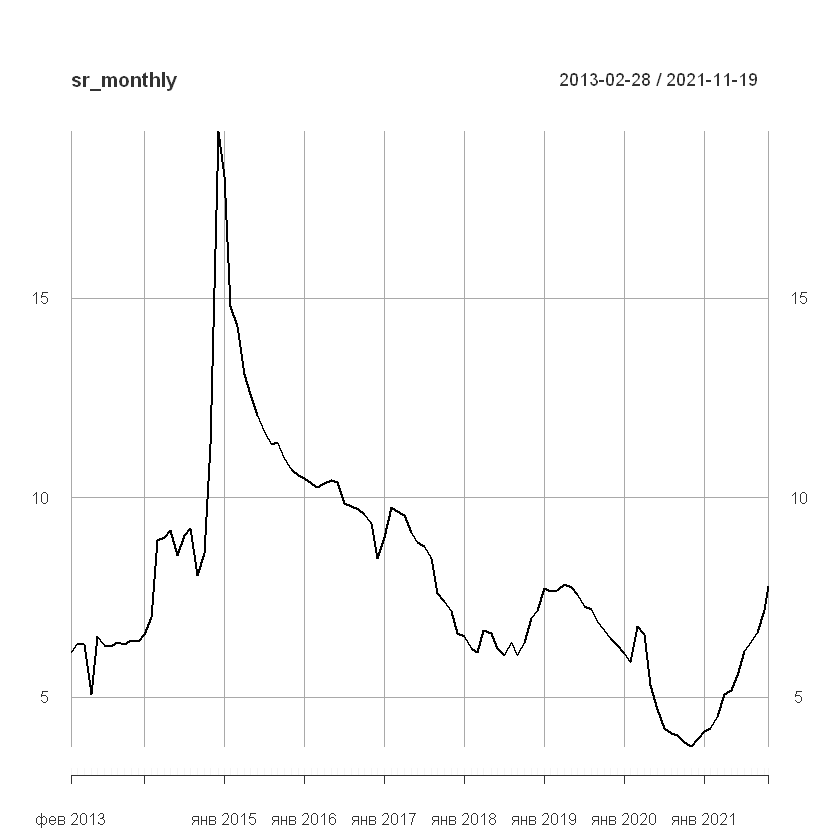

In [287]:
# Creating monthly data for mosprime and nfea swap rates

mp_monthly <- apply.monthly(mp_ts, mean)
sr_monthly <- apply.monthly(sr_ts, mean)

In [436]:
# Merging our series for future VARs

st <- as.Date("2013-02-1")
en <- as.Date("2021-05-1")
dates <- seq(st, en, by = "month")

mp_monthly <- mp_monthly["2013-02/2021-05"]
mp_monthly <- xts(mp_monthly, order.by = dates)
head(mp_monthly)

sr_monthly <- sr_monthly["2013-02/2021-05"]
brent_monthly <- brent_monthly["2013-02/2021-05"]
pr_monthly <- pr_monthly["2013-02/2021-05"]

sr_monthly <- xts(sr_monthly, order.by = dates)
brent_monthly <- xts(brent_monthly, order.by = dates)
pr_monthly <- xts(pr_monthly, order.by = dates)
gdp_monthly <- xts(gdp, order.by = dates)

data <- merge(mp_monthly, sr_monthly, brent_monthly, pr_monthly, gdp_monthly)
names(data) = c("MP", "SR", "Brent", "PR", "GDP")

na.approx(data)

head(data)

                  x
2013-02-01 7.067000
2013-03-01 7.068000
2013-04-01 7.201364
2013-05-01 7.160000
2013-06-01 7.052105
2013-07-01 7.005217

                  MP        SR     Brent    PR       GDP
2013-02-01  7.067000  6.135000 114.14375  8.25 101.44463
2013-03-01  7.068000  6.345789 108.47690  8.25 101.47443
2013-04-01  7.201364  6.333182 102.24818  8.25 101.48869
2013-05-01  7.160000  5.069444 102.58380  8.25 101.48714
2013-06-01  7.052105  6.533684 102.91950  8.25 101.47436
2013-07-01  7.005217  6.309565 107.88348  8.25 101.46044
2013-08-01  6.856818  6.272273 111.28045  8.25 101.45560
2013-09-01  6.792857  6.385714 111.78762  8.25 101.46502
2013-10-01  6.797826  6.322174 109.07652  5.50 101.48339
2013-11-01  6.863500  6.427500 107.95405  5.50 101.50155
2013-12-01  7.078636  6.396364 110.79545  5.50 101.51284
2014-01-01  7.042941  6.584706 108.15370  5.50 101.51954
2014-02-01  7.115500  7.014000 108.94362  5.50 101.52605
2014-03-01  9.005000  8.942500 107.48095  5.50 101.53243
2014-04-01  9.279091  9.016818 107.84659  7.00 101.52835
2014-05-01  9.802105  9.190000 109.53909  7.50 101.49896
2014-06-01  9.570000  8.563158 

                 MP       SR    Brent   PR      GDP
2013-02-01 7.067000 6.135000 114.1437 8.25 101.4446
2013-03-01 7.068000 6.345789 108.4769 8.25 101.4744
2013-04-01 7.201364 6.333182 102.2482 8.25 101.4887
2013-05-01 7.160000 5.069444 102.5838 8.25 101.4871
2013-06-01 7.052105 6.533684 102.9195 8.25 101.4744
2013-07-01 7.005217 6.309565 107.8835 8.25 101.4604

In [437]:
# Making our data stationary

for (i in 1:5){
data[,i] = 400 * Delt(data[,i], typ = "log")
    }
data <- na.omit(data)

## Vector Autoregressions

In [438]:
VARselect(data) # tests suggest order 1 or 3

,1,2,3,4,5,6,7,8,9,10
AIC(n),2.509964e+01,2.494414e+01,2.485576e+01,2.494156e+01,2.522015e+01,2.516085e+01,2.530439e+01,2.521186e+01,2.521897e+01,2.491753e+01
HQ(n),2.543776e+01,2.556403e+01,2.575742e+01,2.612499e+01,2.668535e+01,2.690782e+01,2.733312e+01,2.752237e+01,2.781125e+01,2.779158e+01
SC(n),2.593851e+01,2.648206e+01,2.709273e+01,2.787759e+01,2.885524e+01,2.949499e+01,3.033758e+01,3.094411e+01,3.165028e+01,3.204790e+01
FPE(n),7.963062e+10,6.852681e+10,6.357651e+10,7.106559e+10,9.795674e+10,9.846300e+10,1.247468e+11,1.294790e+11,1.556394e+11,1.460884e+11


In [444]:
# Evaluating VAR(1)

data_var <- VAR(data, p = 1)
summary(data_var)


VAR Estimation Results:
Endogenous variables: MP, SR, Brent, PR, GDP 
Deterministic variables: const 
Sample size: 98 
Log Likelihood: -1954.619 
Roots of the characteristic polynomial:
  0.6   0.6 0.3764 0.3764 0.1086
Call:
VAR(y = data, p = 1)


Estimation results for equation MP: 
MP = MP.l1 + SR.l1 + Brent.l1 + PR.l1 + GDP.l1 + const 

          Estimate Std. Error t value Pr(>|t|)   
MP.l1     0.154106   0.152859   1.008  0.31602   
SR.l1     0.327986   0.112956   2.904  0.00462 **
Brent.l1  0.005527   0.055989   0.099  0.92157   
PR.l1    -0.173086   0.079283  -2.183  0.03157 * 
GDP.l1    1.835201   1.660016   1.106  0.27181   
const    -0.822083   2.465127  -0.333  0.73953   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 24.28 on 92 degrees of freedom
Multiple R-Squared: 0.3152,	Adjusted R-squared: 0.2779 
F-statistic: 8.467 on 5 and 92 DF,  p-value: 1.267e-06 


Estimation results for equation SR: 
SR = MP.l1 + SR.l1 + Brent.l1 +

## Impulse Response Functions

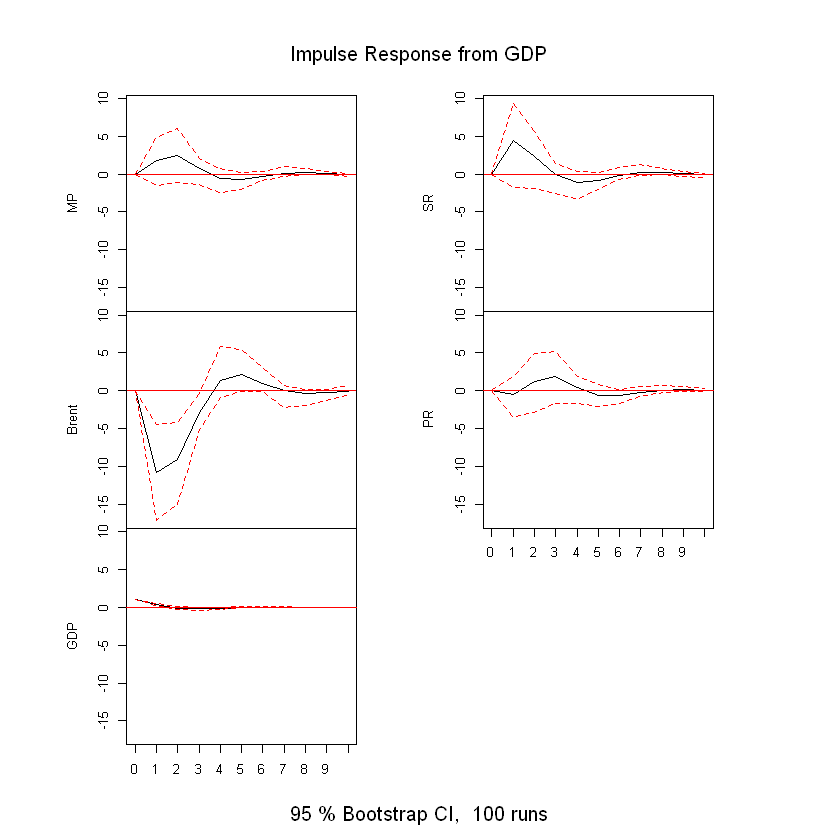

In [459]:
plot(irf(data_var, impulse = "GDP", boot = 500, ortho = F))

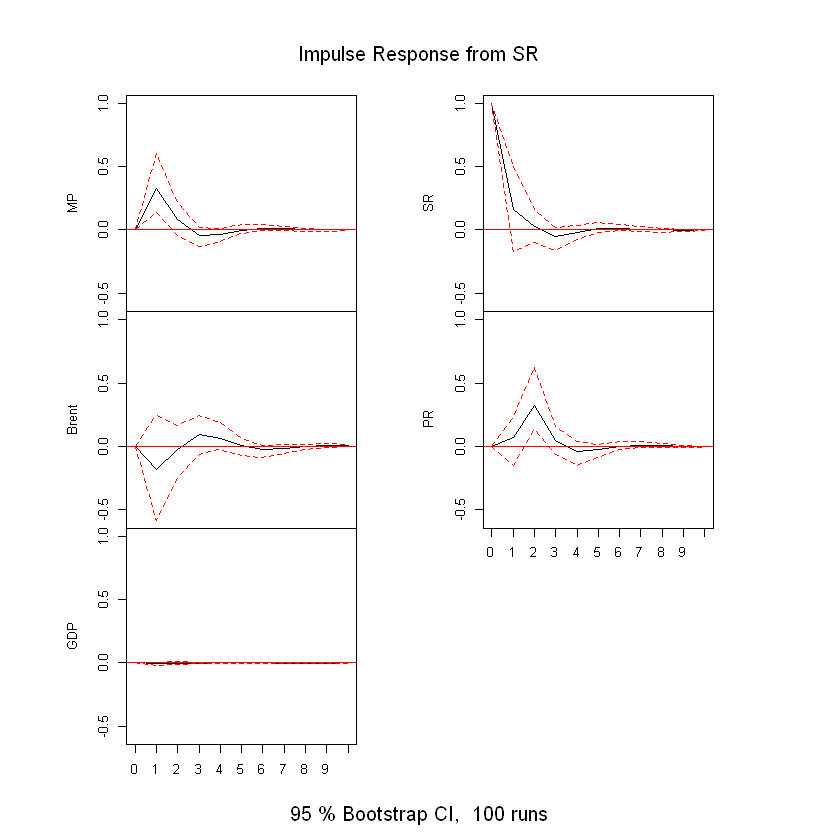

In [460]:
plot(irf(data_var, impulse = "SR", boot = 500, ortho = F))